## run a field-level IMNN on simulations with noise

In [2]:
cd ~/repositories/wl-sbi/imnn_scripts

/home/makinen/repositories/wl-sbi/imnn_scripts


/home/makinen/venvs/lemur/lib64/python3.11/site-packages/IPython/core/magics/osm.py:393: UserWarning: using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/home/makinen/venvs/lemur/lib64/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
import math
import jax
import jax.numpy as jnp
import jax_cosmo as jc
import optax
import matplotlib.pyplot as plt
from functools import partial
import flax.linen as nn

import jax.random as jr

import cloudpickle as pickle


np = jnp

from imnns import *
from imnn_update import *

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f)
        
def load_obj(name):
    with open(name, 'rb') as f:
        return pickle.load(f)


%load_ext autoreload
%autoreload 2

### pull in simulations and compute MOPED for Cls WITH NOISE

In [4]:
z_means_analysis = jnp.array([0.5, 0.75, 1.0, 1.25]) #jnp.array([0.5, 1.0, 1.5, 2.0])

def indices_vector(num_tomo):
   indices = []
   cc = 0
   for catA in range(0,num_tomo,1):
      for catB in range(catA,num_tomo,1):
        indices.append([catA, catB])
        cc += 1
   return indices

L = 500 #250
cl_cut = -1 #13 #6 # 13
skip = 12 #2
num_tomo = 4
Lgrid = (L, L, 4000)
Nmesh = (128,128,512)
num_bins = jnp.ones(Nmesh[0]//2)[:cl_cut:skip].shape[0]
chi_grid = (jnp.arange(Nmesh[2]) + 0.5) * Lgrid[2] / Nmesh[2]
chi_source = chi_grid[-1]
indices = jnp.array(indices_vector(num_tomo))
cl_shape = indices.shape[0] * cl_cut

# NO NOISE FOR NOW
NOISEAMP = 1.0 #0.25


do_noise = True

def compute_variance_catalog(zmean=z_means_analysis):

    N0 = Nmesh[0]
    N1 = Nmesh[1]
    N2 = Nmesh[2]
    L0 = Lgrid[0]
    L1 = Lgrid[1]
    L2 = Lgrid[2]
    
    Ncat = 4

    cosmo = jc.Planck15(Omega_c=0.3, sigma8=0.8) # no sigma8-dependence 
    rms = 0.3 / 2. # from review (corrected w Hall comment)
    a = 1. / (1. + zmean)
    dist = jc.background.radial_comoving_distance(cosmo, a, log10_amin=-3, steps=256)
    angle = 2. * jnp.arctan((L0/N0/2) / dist)
    arcmin_angle = angle * 180. / np.pi * 60.
    arcmin2_pix = arcmin_angle**2
    sources = 30. / Ncat * arcmin2_pix # from Euclid
    return rms**2 / sources

noisevars = compute_variance_catalog()

noisevars

/home/makinen/venvs/lemur/lib64/python3.11/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


Array([2.8138129e-05, 5.4670556e-05, 8.4203231e-05, 1.1463163e-04],      dtype=float32)

In [5]:
@jax.jit
def rotate_sim(k, sim):
    k = k % 4

    condition1 = (k > 0)
    condition2 = (k > 1)
    condition3 = (k > 2)
    condition4 = (k == 3)

    # if k == 0:
    def kzero(k):
        return sim
    # if k == 1:
    def kone(k):
        return jnp.rot90(sim, k=1, axes=(1,2))
    # if k == 2:
    def ktwo(k):
        return jnp.rot90(sim, k=2, axes=(1,2))
    def kthree(k):
        return jnp.rot90(sim, k=3, axes=(1,2))

    # if >2, use kthree, else use ktwo
    def biggerthantwo(k):
        return jax.lax.cond(condition3, true_fun=kthree, false_fun=ktwo, operand=k)

    # if > 1, return biggerthan2, else use kone
    def biggerthanone(k):
        return jax.lax.cond(condition2, true_fun=biggerthantwo, false_fun=kone, operand=k)

    # if >0 , return biggerthan1, else use kzero
    sim = jax.lax.cond(condition1, true_fun=biggerthanone, false_fun=kzero, operand=k)

    return sim

@partial(jax.jit, static_argnums=(3,4))
def noise_simulator(key, sim, noisescale=NOISEAMP, rot=True, noisevars=noisevars):
    key1,key2 = jr.split(key)
    # do rotations of simulations
    k = jr.choice(key1, jnp.array([0,1,2,3]), shape=())
    if rot:
     sim = rotate_sim(k, sim)
    else:
     sim = sim

    # now add noise
    # this generates white noise across all pixels and then increases the amplitude
    sim += (jr.normal(key2, shape=(4,N,N)) * noisescale * jnp.sqrt(noisevars).reshape(4,1,1))
    return sim

In [6]:
from lemur import analysis, background, cosmology, limber, simulate, plot, utils, constants
from moped import *


def get_spec(index, tomo_data, key):
    
    if do_noise:
        tomo_data = noise_simulator(key, tomo_data)
    
    return analysis.compute_auto_cross_angular_power_spectrum(tomo_data[index[0]], tomo_data[index[1]],
                                                chi_source, Lgrid[0])[1][:cl_cut:skip]

def cls_allbins(tomo_data, key):
    gps = lambda i: get_spec(i, tomo_data, key)
    return jax.vmap(gps)(indices)



def get_spec_nonoise(index, tomo_data):

    return analysis.compute_auto_cross_angular_power_spectrum(tomo_data[index[0]], tomo_data[index[1]],
                                                chi_source, Lgrid[0])[1][:cl_cut:skip]

def cls_allbins_nonoise(tomo_data):
    gps = lambda i: get_spec_nonoise(i, tomo_data)
    return jax.vmap(gps)(indices)


In [7]:
from tqdm import tqdm as tq

### ------------- IMNN PARAMETERS -------------
#θ_fid = jnp.array([0.5, 1.162]) #jnp.array([0.5, 0.67])
θ_fid = jnp.array([0.3, 0.8])
δθ = 2*jnp.array([0.0215, 0.02]) # BIG DERV STEP

θ_der = (θ_fid + jnp.einsum("i,jk->ijk", jnp.array([-1., 1.]), jnp.diag(δθ) / 2.)).reshape((-1, 2))


n_summaries = 2

n_s = 1500
n_d = 750 // 2 #125

n_params = 2
n_summaries = n_params
print(θ_der)

N = 128
L = Lgrid[0]
lpt_order = 2
outdir = "/data101/makinen/lemur_sims/first_analysis/"


fid = jnp.load(outdir + "fid_S8_L_%d_N_%d_Nz_512_LPT%d_Om_%d_s8_%d.npy"%(L, N, lpt_order, θ_fid[0]*10, θ_fid[1]*10)) 
#fid = jnp.load(outdir + "fid_tomo_L_%d_N_%d_Nz_512_LPT%d.npy"%(L, N, lpt_order))
derv = jnp.load(outdir + "derv_bigstep_S8_L_%d_N_%d_Nz_512_LPT%d_Om_%d_s8_%d.npy"%(L, N, lpt_order, θ_fid[0]*10, θ_fid[1]*10))[:n_d*2]
#derv = jnp.load(outdir + "derv_tomo_L_%d_N_%d_Nz_512_LPT%d.npy"%(L, N, lpt_order))

key = jr.PRNGKey(7777)
key,rng = jr.split(key)

fid_keys = jr.split(key, num=2*n_s)
derv_keys = jr.split(rng, num=2*n_d)
derv_keys = jnp.repeat(derv_keys, θ_der.shape[0], axis=0) # flattened repeated keys


# ----- DO MOPED WITH ALL SIMS (NOISEFREE) -----
fid_cls = []
batch = 50
for i in tq(range(fid.shape[0] // batch)):
    f_ = jax.vmap(cls_allbins)(fid[i*batch:(i+1)*batch], fid_keys[i*batch:(i+1)*batch]).reshape(-1, len(indices)*(num_bins))
    fid_cls.append(f_)

fid_cls = jnp.concatenate(fid_cls)

derv_cls = []
batch = 50
for i in tq(range(n_d*2*2*n_params // batch)):
    d_  = jax.vmap(cls_allbins)(derv.reshape(-1, num_tomo, Nmesh[0], Nmesh[1])[i*batch:(i+1)*batch], 
                               derv_keys[i*batch:(i+1)*batch])
    derv_cls.append(d_)

derv_cls = jnp.concatenate(derv_cls).reshape(n_d*2, 2, n_params, len(indices)*(num_bins))
# ----- -----

cl_shape = derv_cls.shape[-1]
# now initialise MOPED object


[[0.27850002 0.8       ]
 [0.3        0.78000003]
 [0.3215     0.8       ]
 [0.3        0.82      ]]


100%|██████████| 60/60 [00:00<00:00, 67.64it/s]


In [8]:
ell,clsfoo = analysis.compute_auto_cross_angular_power_spectrum(fid[59, 0], fid[59, 0], chi_source, Lgrid[0])
np.argmin((ell - 1000)**2)

Array(19, dtype=int32)

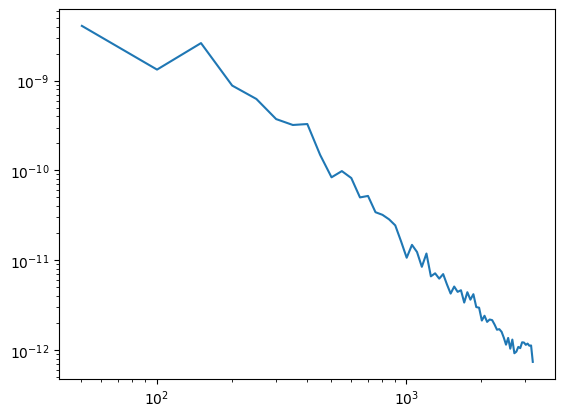

In [9]:
plt.loglog(ell, clsfoo)

In [10]:
mymoped = MOPED(n_param=2, n_d=n_d*2, n_s=n_s*2, 
                input_shape=fid_cls[0].shape, 
                fiducial=fid_cls, 
                derivatives=derv_cls, 
                δθ=δθ, 
                θ_fid=θ_fid
               )

moped_summs = mymoped.compress(fid_cls)

# next we're going to do a second moped compression to get the derivatives into a smaller space.
# you can check to see that the fisher is the same for both !
mymoped2 = MOPED(
                n_param=2, n_d=n_d*2, n_s=n_s*2, 
                input_shape=(2,), 
                fiducial=mymoped.compress(fid_cls), 
                derivatives=mymoped.compress(derv_cls.reshape((-1,) + fid_cls[0].shape)).reshape(n_d*2, 2, 2, 2), 
                δθ=δθ, 
                θ_fid=θ_fid
)

print("moped 2 F:", mymoped2.F, "moped 1 F:", mymoped.F)
print("moped 2 F:", jnp.linalg.det(mymoped2.F), "moped 1 F:", jnp.linalg.det(mymoped.F))

moped_statistic = dict(
        n_t = 2,
        mean_derivatives = mymoped2.mu_dervs,
        covariance = mymoped.invF,
        Fisher = mymoped.F,
        fid_summaries=mymoped.compress(fid_cls),
)

moped 2 F: [[1005.01965  605.5396 ]
 [ 605.5396   488.19412]] moped 1 F: [[1005.01996  605.5386 ]
 [ 605.54016  488.19443]]
moped 2 F: 123966.47 moped 1 F: 123967.22


In [11]:
# split into train and val sets

val_fid = fid[n_s:]
val_derv = derv[n_d:]

fid = fid[:n_s]
derv = derv[:n_d]

(fid.shape, derv.shape), (val_fid.shape, val_derv.shape)

(((1500, 4, 128, 128), (375, 2, 2, 4, 128, 128)),
 ((1500, 4, 128, 128), (375, 2, 2, 4, 128, 128)))

# NPE code

In [12]:
from NPE import npe
from NPE.multipole_cnn import MultipoleConv
from NPE.multipole_cnn_factory import MultipoleCNNFactory

## network code

In [13]:
# load mdn thing
from typing import Sequence, Callable
import jax
from jax.scipy.special import logsumexp # Compute the log of the sum of exponentials of input elements
from jax.nn import softmax # pretty much the same as the interface as the one in scipy.special

import flax.linen as nn

np = jnp

import cloudpickle as pickle

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f)

def load_obj(name):
    with open(name, 'rb') as f:
        return pickle.load(f)


class MLP(nn.Module):
  features: Sequence[int]
  act: nn.activation = nn.tanh

  @nn.compact
  def __call__(self, x):
    for feat in self.features[:-1]:
      x = self.act(nn.Dense(feat)(x))
    x = nn.Dense(self.features[-1])(x)
    return x

key = jax.random.PRNGKey(33)
n_mixture = 5
n_hidden = 20
batch_size = 128*128*4

# get output from network
features = [n_hidden, n_hidden, n_mixture*3]
mdn_pixel = MLP(features)

mdn_pixel_net = mdn_pixel.apply

# load fixed parameters
mdn_params = load_obj("/home/makinen/repositories/wl-sbi/mdn_idea/mdn_params_target.pkl")

logSqrtTwoPI = onp.log(onp.sqrt(2.0 * onp.pi))

def lognormal(y, mean, logstd):
  return -0.5 * ((y - mean) / np.exp(logstd)) ** 2 - logstd - logSqrtTwoPI

def lognormal(y, mean, logstd):
  return -0.5 * ((y - mean) / np.exp(logstd)) ** 2 - logstd - logSqrtTwoPI

def get_mdn_coef(output):
  logmix, mean, logstd = np.split(output, 3, axis=1)
  logmix = logmix - logsumexp(logmix, 1, keepdims=True)
  return logmix, mean, logstd

def mdn_loss_func(logmix, mean, logstd, y):
  v = logmix + lognormal(y, mean, logstd)
  v = logsumexp(v, axis=1)
  return -np.mean(v)


def get_summaries_mdn(x, network=mdn_pixel_net, params=mdn_params, data_scale=100):
    x *= data_scale
    logmix, mu_data, logstd = get_mdn_coef(network(params, x))
    #pi_data = softmax(logmix)
    #sigma_data = jnp.exp(logstd)
    return jnp.concatenate([-jnp.mean(jnp.concatenate([logmix,mu_data,logstd,], -1), 0),
                            jnp.var(jnp.concatenate([logmix,mu_data,logstd,], -1), 0)], -1)




In [14]:
foo = get_summaries_mdn(fid[78].reshape(-1, 1))

In [15]:
foo.shape

(30,)

In [16]:
from typing import Any, Callable, Sequence, Optional, Union
from flax.core import freeze, unfreeze
import flax.linen as nn

import jax
import jax.numpy as jnp

Array = Any

@jax.jit
def almost_leaky(x: Array) -> Array:
  r"""Almost Leaky rectified linear unit activation function.

  Computes the element-wise function:

  .. math::
    \mathrm{almost\_leaky}(x) = \begin{cases}
      x, & x \leq -1\\
      - |x|^3/3, & -1 \leq x < 1\\
      3x & x > 1
    \end{cases}

  Args:
    x : input array
  """
  return jnp.where(x < -1, x, jnp.where((x < 1), ((-(jnp.abs(x)**3) / 3) + x*(x+2) + (1/3)), 3*x)) / 3.5



def next_power_of_two(number):
    # Returns next power of two following 'number'
    return math.ceil(math.log2(number))

def conv_outs(W, K=2, P=0, S=3):
    return math.ceil(((W - K + (2*P)) / S )+1)

#@jax.jit
def get_padding(arraylen):
    """
    helper function to pad uneven strided outputs
    """
    
    next_power = next_power_of_two(arraylen)
    deficit = int(math.pow(2, next_power) - arraylen) # how much extra to pad
    
    # but we want to pad both sides of a given axis, so return a tuple here
    
    left = deficit // 2
    right = left + (deficit % 2)
    
    return (left, right)


# TODO: try maxpool layer in one of the blocks ?


class InceptStride(nn.Module):
    """Inception block submodule"""
    filters: Sequence[int]
    pad_shape: int
    act: Callable = almost_leaky
    do_1x1: bool = True
    do_4x4: bool = True

    @nn.compact
    def __call__(self, x):

            
        # 2x2 stride
        x2 = nn.Conv(features=self.filters[0], kernel_size=(2,2), strides=(2,2), padding="CIRCULAR")(x)
        x2 = self.act(x2)
        x2 = nn.Conv(features=self.filters[0], kernel_size=(2,2), strides=(1,1), padding="CIRCULAR")(x2)
        x2 = self.act(x2)

        # 2x2 stride with pool
        x2p = nn.Conv(features=self.filters[0], kernel_size=(2,2), strides=(2,2), padding="CIRCULAR")(x)
        x2p = self.act(x2p)
        x2p = nn.max_pool(x2p, (4,4), strides=None, padding="SAME")
        

        # 3x3 stride
        x3 = nn.Conv(features=self.filters[1], kernel_size=(2,2), strides=(3,3), padding="CIRCULAR")(x)
        x3 = self.act(x3)
        x3 = nn.Conv(features=self.filters[1], kernel_size=(2,2), strides=(1,1), padding="CIRCULAR")(x3)
        x3 = self.act(x3)

        # 4x4 stride
        if self.do_4x4:
            x4 = nn.Conv(features=self.filters[1], kernel_size=(2,2), strides=(4,4), padding="CIRCULAR")(x)
            x4 = self.act(x4)
            x4 = nn.Conv(features=self.filters[1], kernel_size=(2,2), strides=(1,1), padding="CIRCULAR")(x4)
            x4 = self.act(x4)

        
        # now pad the 3x3 and concatenate it to the 2x2 stride
        x3shape = conv_outs(W=self.pad_shape)
        pads = get_padding(x3shape)
        
        x3 = jnp.pad(x3, pad_width=(pads, pads, (0,0),), mode="wrap")
        x2 = jnp.concatenate([x2, x2p, x3], -1)

        # run another conv for the concated versions
        x2 = nn.Conv(features=self.filters[0], kernel_size=(2,2), strides=(1,1), padding="CIRCULAR")(x2)
        x2 = self.act(x2)
        

        # optional no stride embedding
        if self.do_1x1:
            x1 = nn.Conv(features=self.filters[2], kernel_size=(2,2), strides=(1,1), padding="CIRCULAR")(x)
            x1 = self.act(x1)
            x1 = nn.Conv(features=self.filters[2], kernel_size=(2,2), strides=(1,1), padding="CIRCULAR")(x1)
            x1 = self.act(x1)

            return x1, x2, x4

        elif self.do_4x4:
            return x2, x4

        else:
            return x2





class MPK_net(nn.Module):
    """An incept net architecture"""
    filters: Sequence[int]
    #mlp_features: Sequence[int]
    # multipole_tomo1: MultipoleConv
    # multipole_tomo2: MultipoleConv
    # multipole_tomo3: MultipoleConv
    # multipole_tomo4: MultipoleConv
    multipole_cnn1: MultipoleConv
    # multipole_cnn2: MultipoleConv
    # multipole_cnn3: MultipoleConv
    # multipole_cnn4: MultipoleConv
    div_factor: float = 0.02
    n_outs: int = 1
    act: Callable = almost_leaky

    
    @nn.compact
    def __call__(self, x):

        filters = self.filters

        # add in Cls information
        cls_summs = cls_allbins_nonoise(jax.lax.stop_gradient(x)).reshape(-1, cl_shape)
        cls_summs = mymoped.compress(jax.lax.stop_gradient(cls_summs)).reshape(-1) # moped compress
        #cls_summs = jnp.log(jax.lax.stop_gradient(cls_summs)) + 22

        # do field-level net
        x = jnp.transpose(x, (1, 2, 0))

        x *= 150.0 #/= 0.02 #np.sqrt(noisevars)
        #x = x[..., jnp.newaxis] # expand dims for 3D conv

        # first pass to NPE layer -> 128x128 x 6 filters
        x = self.multipole_cnn1(x) # input filters: 4, output: 6
        #x1 = self.multipole_tomo1(x[..., 0][..., jnp.newaxis])
        #x2 = self.multipole_tomo2(x[..., 1][..., jnp.newaxis])
        #x3 = self.multipole_tomo3(x[..., 2][..., jnp.newaxis])
        #x4 = self.multipole_tomo4(x[..., 3][..., jnp.newaxis])

        # stack in filter dimension
        #x = jnp.concatenate([x1, x2, x3, x4], -1)
        x = self.act(x)

        # outputs are now (128,128, 24) long

        # do a few MPK layers over these inputs -> out filters: 6
        #x = self.multipole_cnn2(x) # input filters: 6, output: 6
        #x = self.act(x)
        
        #x = self.multipole_cnn3(x) # input filters: 6, output: 6
        #x = self.act(x)

        # input is now (128,128,6)

        # do incept net out

        x_1_64, x_1_32 = InceptStride(filters=filters, pad_shape=128, act=self.act, do_1x1=False)(x)

        # continue along the tree (no stride-1 this time)
        x_2_32, x_2_16 = InceptStride(filters=filters, pad_shape=64, act=self.act, do_1x1=False)(x_1_64)

        # now concatenate the remaining 32x32 arrays
        x_2_32 = jnp.concatenate([x_1_32, x_2_32], -1)

        # now cut down to 16x16
        x_3_16, x_2_8 = InceptStride(filters=filters, pad_shape=32, act=self.act, do_1x1=False)(x_2_32)

        # concatenate the remaining 16x16 array
        x_3_16 = jnp.concatenate([x_2_16, x_3_16], -1)

        # now cut down to 8x8
        x_3_8, x_2_4 = InceptStride(filters=filters, pad_shape=16, act=self.act, do_1x1=False)(x_3_16)

        # concatenate the 8x8s
        x_3_8 = jnp.concatenate([x_2_8, x_3_8], -1)

        # cut down to 2 and then downconv out
        x_3_4, x_2_2 = InceptStride(filters=filters, pad_shape=8, act=self.act, do_1x1=False)(x_3_8)

        # concatenate the 4x4s
        x_3_4 = jnp.concatenate([x_2_4, x_3_4], -1)

        # down to 1x1
        x_3_2 = InceptStride(filters=filters, act=self.act, pad_shape=4, do_1x1=False, do_4x4=False)(x_3_4)

        # concatenate the 2x2s
        x = jnp.concatenate([x_2_2, x_3_2], -1) # output should be (1,1, filters)

        x = nn.Conv(features=filters[0]*2, kernel_size=(2,2), strides=(2,2), padding='CIRCULAR')(x)
        x = self.act(x)
        
        
        # # conv or sum everything and send it out
        x = x.reshape(1, -1)
        #print(x.shape)

        x = nn.Dense(100)(x)
        x = self.act(x)
        x = nn.Dense(100)(x)
        x = self.act(x)
        x = nn.Dense(self.n_outs*2)(x)

        x = jnp.linalg.inv(nn.softplus(x[:, :1])) @ x[:, 1:]
        x = x.reshape(-1)

        
        # x = nn.Conv(features=filters[0], kernel_size=(5,))(x)
        # x = self.act(x)
        # x = nn.Conv(features=filters[0], kernel_size=(5,))(x)
        # x = self.act(x)
        # x = nn.Conv(features=self.n_outs, kernel_size=(1,))(x)
        # x = self.act(x)
        # x = nn.Conv(features=self.n_outs, kernel_size=(1,))(x.reshape(1, -1)).reshape(-1)

        # x = nn.Conv(features=2, kernel_size=(1,))(x.reshape(1, -1))

        # x = jnp.linalg.inv(nn.softplus(x[:, :1])) @ x[:, 1:]
        
        # x = x.reshape(-1)

        return jnp.concatenate([cls_summs.reshape(-1), x])



In [73]:
class MPK_layer(nn.Module):
    multipole_layers: Sequence[MultipoleConv]
    act: Callable = almost_leaky

    @nn.compact
    def __call__(self, x):
        for l in self.multipole_layers:
            x = l(x)
            x = self.act(x)
        return x
        


class MDN_net_stacked(nn.Module):
    """An incept net architecture"""
    filters: Sequence[int]
    #mlp_features: Sequence[int]
    multipole_tomo1: MPK_layer
    #multipole_tomo2: MPK_layer
    #multipole_tomo3: MPK_layer
    #multipole_tomo4: MPK_layer
    # mpk_stack1: MPK_layer
    # mpk_stack2: MPK_layer
    # mpk_stack3: MPK_layer
    # mpk_stack4: MPK_layer
    # mpk_stack5: MPK_layer
    div_factor: float = 0.02
    n_outs: int = 1
    act: Callable = nn.swish

    
    @nn.compact
    def __call__(self, x):

        filters = self.filters

        # add in Cls information
        cls_summs = cls_allbins_nonoise(jax.lax.stop_gradient(x)).reshape(-1, cl_shape)
        cls_summs = mymoped.compress(jax.lax.stop_gradient(cls_summs)).reshape(-1) # moped compress
        #cls_summs = jnp.log(jax.lax.stop_gradient(cls_summs)) + 22

        # pass to trained mdn layer
        mdn_summs = get_summaries_mdn(jax.lax.stop_gradient(x).reshape(-1, 1))
        

       # do field-level net
        x = jnp.transpose(x, (1, 2, 0))

        x *= 150

        # def gethist(data):
        #   return jnp.histogram(data, bins=7, density=True)[0]

        # xd = jax.vmap(gethist)(x.T).reshape(-1)

        x0 = x
        x = self.multipole_tomo1(x)

        x = jnp.concatenate([x0, x], -1)

        #x, x_0_64, x_0_32 = InceptStride(filters=filters, pad_shape=128, act=self.act, do_1x1=True)(x)

        # incept net out
        x_1_64, x_1_32 = InceptStride(filters=filters, pad_shape=128, act=self.act, do_1x1=False)(x)

        #x_1_64 = jnp.concatenate([x_1_64, x_0_64], -1)
        #x_1_32 = jnp.concatenate([x_1_32, x_0_32], -1)

        # continue along the tree (no stride-1 this time)
        x_2_32, x_2_16 = InceptStride(filters=filters, pad_shape=64, act=self.act, do_1x1=False)(x_1_64)
        # now concatenate the remaining 32x32 arrays
        x_2_32 = jnp.concatenate([x_1_32, x_2_32], -1)
        # now cut down to 16x16
        x_3_16, x_2_8 = InceptStride(filters=filters, pad_shape=32, act=self.act, do_1x1=False)(x_2_32)
        # concatenate the remaining 16x16 array
        x_3_16 = jnp.concatenate([x_2_16, x_3_16], -1)
        # now cut down to 8x8
        x_3_8, x_2_4 = InceptStride(filters=filters, pad_shape=16, act=self.act, do_1x1=False)(x_3_16)
        # concatenate the 8x8s
        x_3_8 = jnp.concatenate([x_2_8, x_3_8], -1)
        # cut down to 2 and then downconv out
        x_3_4, x_2_2 = InceptStride(filters=filters, pad_shape=8, act=self.act, do_1x1=False)(x_3_8)
        # concatenate the 4x4s
        x_3_4 = jnp.concatenate([x_2_4, x_3_4], -1)
        # down to 1x1
        x_3_2 = InceptStride(filters=filters, act=self.act, pad_shape=4, do_1x1=False, do_4x4=False)(x_3_4)
        # concatenate the 2x2s
        x = jnp.concatenate([x_2_2, x_3_2], -1) # output should be (1,1, filters)
        
        x = nn.Conv(filters[0], (2,2), strides=2, padding="CIRCULAR")(x)
        x = self.act(x)
        #print("x", x.shape)
        
        x = jnp.concatenate([x.reshape(-1), mdn_summs], -1)
        #x = mdn_summs
        #x = x.reshape(1, -1)
        x = nn.Dense(128)(x)
        x = self.act(x)
        x = nn.Dense(128)(x)
        x = self.act(x)
        x = nn.Dense(128)(x)
        x = self.act(x)
        #x = nn.Dense(self.n_outs)(x)
        x = nn.Dense(self.n_outs*2)(x).reshape(1,-1)
        #x = jnp.linalg.inv(nn.softplus(x[:, :1])) @ x[:, 1:]
        x = x.reshape(-1)

        return jnp.concatenate([cls_summs.reshape(-1), x])




In [82]:
# test out layers


factory = MultipoleCNNFactory(kernel_shape=(5,5),
                              polynomial_degrees=[0,1],
                              output_filters=None)

npe = factory.build_cnn_model(pad_size=None, backend="lax", num_input_filters=1, strides=3)

key = jax.random.PRNGKey(42)
dummy_input = jax.random.normal(key, shape=(128,128,1)) #.reshape([5, 5])
init_model_params = npe.init(key, dummy_input)

outs = npe.apply(init_model_params, dummy_input)

In [117]:
npe.multipole_kernels.shape

(24, 5, 5, 3)

In [118]:
outs.shape

(43, 43, 3)

In [119]:
fid.shape

(1500, 4, 128, 128)

In [76]:
mpk_layer = MultipoleCNNFactory(kernel_shape=(33,33),
             polynomial_degrees=[0,1,2],
             output_filters=None)


input_filters = [4]
strides = [1,1]

stacks = MPK_layer(multipole_layers=[mpk_layer.build_cnn_model(num_input_filters=f,
                                                               strides=strides[i],
                                                               pad_size=None) for i,f in enumerate(input_filters)],
                  act=nn.swish)

dummy_input = jax.random.normal(key, shape=(128,128,4)) #.reshape([5, 5])
init_model_params = stacks.init(key, dummy_input)

foo = noise_simulator(key, fid[0], noisescale=1.0).T[..., :] / 0.02

#foo /= foo.std()
outs = stacks.apply(init_model_params,  foo)

In [77]:
foo.shape

(128, 128, 4)

In [78]:
outs.shape

(128, 128, 6)

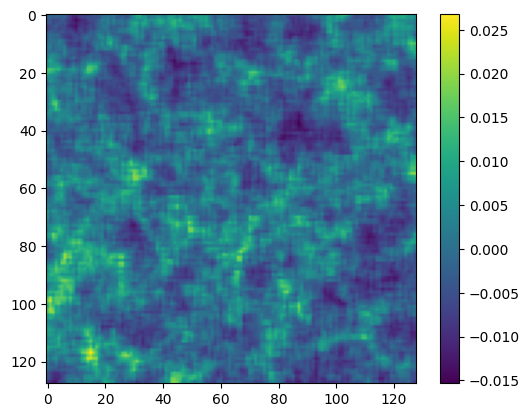

In [79]:
plt.imshow(fid[10, 1, ...])
plt.colorbar()

In [80]:
outs.shape

(128, 128, 6)

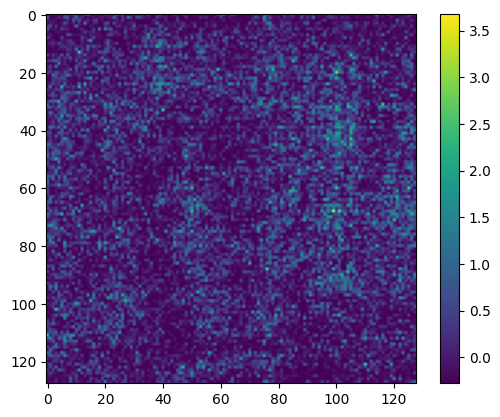

In [95]:
plt.imshow(outs[..., 3])
plt.colorbar()

In [29]:
foo = nn.Dense(10)
wfoo = foo.init(key, jnp.ones(4))

In [30]:
wfoo

{'params': {'kernel': Array([[ 0.37861145,  0.22321299,  0.49279484,  0.44863197,  1.1029023 ,
           0.42319104,  0.1816966 , -0.80084467,  0.77922654, -0.2571976 ],
         [-0.4369551 ,  0.37554103, -0.5133883 ,  0.39811015, -0.57343113,
          -0.33252883,  0.08150671, -0.01746338,  0.05329918, -0.3778651 ],
         [ 1.018824  , -0.20852381, -0.37136924,  0.5518285 ,  0.73846954,
          -0.18702292, -0.02514149,  0.27473184,  0.09506938, -0.48267725],
         [-0.57757205,  0.1447315 , -0.02636662, -0.7096944 , -0.16962223,
          -0.07820706, -0.7282153 ,  0.2279144 ,  0.11688985,  0.49813566]],      dtype=float32),
  'bias': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)}}

In [31]:
foo.apply(wfoo, jnp.ones((128,128,4))).shape

(128, 128, 10)

In [115]:
#model = nn.Conv(features=5, kernel_size=(2,2), strides=3, padding="CIRCULAR")
#model = InceptNet(filters=[5,5,20])

# maybe do each tomo bin separately, concatenate, and then continue with downconvs 

pole_layer1 = MultipoleCNNFactory(kernel_shape=(3,3),
             polynomial_degrees=[0],
             output_filters=None)


mpk_layer = MultipoleCNNFactory(
             kernel_shape=(7,7),
            #kernel_shape=(7,7),
             polynomial_degrees=[0,1,2],
             output_filters=None)



strides1 = [1,1]
strides2 = [1,1]
strides3 = [1,1]
strides4 = [1,1]
strides5 = [1,1]

input_filters1 = [4,1,1]

input_filters_rest = [4]

act = nn.swish


model = MDN_net_stacked(filters=[3,3,3], 
                        # rest of network
                        multipole_tomo1 = MPK_layer(multipole_layers=[mpk_layer.build_cnn_model(num_input_filters=f,
                                                                   strides=strides1[i],
                                                                   pad_size=None) for i,f in enumerate(input_filters_rest)],
                                                                   act=act),
                        act=act, 
                        n_outs=1
)

w = model.init(jr.PRNGKey(44), jnp.zeros((4, N, N)))

x = model.apply(w, fid[0])

x

Array([-0.26444954,  0.6502684 , -0.08116543,  0.06987164], dtype=float32)

In [116]:
L/N * 7, L/N * 3

(27.34375, 11.71875)

In [117]:
import netket as nk
from jax import config
config.update("jax_enable_x64", False)

In [118]:
pwd

'/home/makinen/repositories/wl-sbi/imnn_scripts'

In [119]:
from imnns import *
from imnn_update import *
from imnn_update import _updateIMNN, _check_input
import netket as nk




# NOISE NUMERICAL GRADIENT IMNN
class newNoiseNumericalGradientIMNN(_updateIMNN):
    """Information maximising neural network fit with simulations on-the-fly
    """
    def __init__(self, n_s, n_d, n_params, n_summaries, input_shape, θ_fid, δθ,
                 model, optimiser, key_or_state,
                 noise_simulator, 
                 fiducial, derivative,
                 chunk_size=100,
                 validation_fiducial=None, validation_derivative=None, 
                 existing_statistic=None,
                 dummy_graph_input=None,
                 no_invC=False, do_reg=True,
                 evidence=False):
        """Constructor method

        Initialises all IMNN attributes, constructs neural network and its
        initial parameter values and creates history dictionary. Also checks
        validity of simulator and sets the ``simulate`` attribute to ``True``.

        Parameters
        ----------
        n_s : int
            Number of simulations used to calculate summary covariance
        n_d : int
            Number of simulations used to calculate mean of summary derivative
        n_params : int
            Number of model parameters
        n_summaries : int
            Number of summaries, i.e. outputs of the network
        input_shape : tuple
            The shape of a single input to the network
        θ_fid : float(n_params,)
            The value of the fiducial parameter values used to generate inputs
        model : tuple, len=2
            Tuple containing functions to initialise neural network
            ``fn(rng: int(2), input_shape: tuple) -> tuple, list`` and the
            neural network as a function of network parameters and inputs
            ``fn(w: list, d: float(None, input_shape)) -> float(None, n_summari
            es)``.
            (Essentibly stax-like, see `jax.experimental.stax <https://jax.read
            thedocs.io/en/stable/jax.experimental.stax.html>`_))
        optimiser : tuple, len=3
            Tuple containing functions to generate the optimiser state
            ``fn(x0: list) -> :obj:state``, to update the state from a list of
            gradients ``fn(i: int, g: list, state: :obj:state) -> :obj:state``
            and to extract network parameters from the state
            ``fn(state: :obj:state) -> list``.
            (See `jax.experimental.optimizers <https://jax.readthedocs.io/en/st
            able/jax.experimental.optimizers.html>`_)
        key_or_state : int(2) or :obj:state
            Either a stateless random number generator or the state object of
            an preinitialised optimiser
        simulator : fn
            A function that generates a single simulation from a random number
            generator and a tuple (or array) of parameter values at which to
            generate the simulations. For the purposes of use in LFI/ABC
            afterwards it is also useful for the simulator to be able to
            broadcast to a batch of simulations on the zeroth axis
            ``fn(int(2,), float([None], n_params)) ->
            float([None], input_shape)``
        dummy_graph_input : jraph.GraphsTuple or 'jax.numpy.DeviceArray'
            Either a (padded) graph input or device array. If supplied ignores 
            `input_shape` parameter
        """
        super().__init__(
            n_s=n_s,
            n_d=n_d,
            n_params=n_params,
            n_summaries=n_summaries,
            input_shape=input_shape,
            θ_fid=θ_fid,
            model=model,
            optimiser=optimiser,
            key_or_state=key_or_state,
            existing_statistic=existing_statistic,
            dummy_graph_input=dummy_graph_input,
            no_invC=no_invC,
            do_reg=do_reg,
            evidence=evidence)

        self.chunk_size = chunk_size
        self.existing_statistic = existing_statistic
        self.simulator = noise_simulator
        #self.simulate = True
        self.dummy_graph_input = dummy_graph_input
        self.θ_der = (θ_fid + np.einsum("i,jk->ijk", np.array([-1., 1.]), 
                                        np.diag(δθ) / 2.)).reshape((-1, 2))
        self.δθ = np.expand_dims(
            _check_input(δθ, (self.n_params,), "δθ"), (0, 1))
        
        # NUMERICAL GRADIENT SETUP
        self._set_data(δθ, fiducial, derivative, validation_fiducial,
                       validation_derivative)


    def _set_data(self, δθ, fiducial, derivative, validation_fiducial,
                  validation_derivative):
        """Checks and sets data attributes with the correct shape
        """
        self.δθ = np.expand_dims(
            _check_input(δθ, (self.n_params,), "δθ"), (0, 1))
        if self.dummy_graph_input is None:
          self.fiducial = _check_input(
              fiducial, (self.n_s,) + self.input_shape, "fiducial")
          self.derivative = _check_input(
              derivative, (self.n_d, 2, self.n_params) + self.input_shape,
              "derivative")
          if ((validation_fiducial is not None)
                  and (validation_derivative is not None)):
              self.validation_fiducial = _check_input(
                  validation_fiducial, (self.n_s,) + self.input_shape,
                  "validation_fiducial")
              self.validation_derivative = _check_input(
                  validation_derivative,
                  (self.n_d, 2, self.n_params) + self.input_shape,
                  "validation_derivative")
              self.validate = True
        else:
          self.fiducial = fiducial
          self.derivative = derivative

          if ((validation_fiducial is not None)
                  and (validation_derivative is not None)):
              self.validation_fiducial = validation_fiducial
              self.validation_derivative =  validation_derivative
              self.validate = True


    def _collect_input(self, key, validate=False):
        """ Returns validation or fitting sets
        """
        if validate:
            fiducial = self.validation_fiducial
            derivative = self.validation_derivative
        else:
            fiducial = self.fiducial
            derivative = self.derivative
            
        # add noise to data and make cuts
        keys = np.array(jax.random.split(key, num=self.n_s))
        fiducial = jax.vmap(self.simulator)(keys, fiducial)
        
        _shape = derivative.shape
        derivative = jax.vmap(self.simulator)(
                np.repeat(keys[:self.n_d], 2*self.n_params, axis=0),
                derivative.reshape(
                      (self.n_d * 2 * self.n_params,) + self.input_shape)).reshape(_shape)
                      
        return fiducial, derivative

    def _get_fitting_keys(self, rng):
        """Generates random numbers for simulation

        Parameters
        ----------
        rng : int(2,)
            A random number generator

        Returns
        -------
        int(2,), int(2,), int(2,)
            A new random number generator and random number generators for
            fitting (and validation)
        """
        return jax.random.split(rng, num=3)

    def get_summaries(self, w, key=None, validate=False):
        """Gets all network outputs and derivatives wrt model parameters
        """
        d, d_mp = self._collect_input(key, validate=validate)
        
        
        if self.dummy_graph_input is None:
          _model = lambda d: self.model(w, d)
          # try the netket batched vmap
          # nk.jax.vmap_chunked(f, in_axes=0, *, chunk_size, axis_0_is_sharded=False)
          x = nk.jax.vmap_chunked(_model, chunk_size=self.chunk_size)(d)
          x_mp = np.reshape(
              nk.jax.vmap_chunked(_model, chunk_size=self.chunk_size)(
                    d_mp.reshape(
                      (self.n_d * 2 * self.n_params,) + self.input_shape)),
              (self.n_d, 2, self.n_params, self.n_summaries))

        else:
          # if operating on graph data, we need to vmap the implicit
          # batch dimension
          _model = lambda d: self.model(w, d)
          x = jax.vmap(_model)(d)
          x_mp = np.reshape(
              jax.vmap(_model)(d_mp),
              (self.n_d, 2, self.n_params, self.n_summaries))

        return x, x_mp

    def _construct_derivatives(self, x_mp):
        """Builds derivatives of the network outputs wrt model parameters
        """
        return np.swapaxes(x_mp[:, 1] - x_mp[:, 0], 1, 2) / self.δθ


In [120]:


#model = InceptNet(filters=[5,5,5], multipole_cnn=pole_layer, act=nn.swish, n_outs=1) # nn.swish

lr_schedule = optax.exponential_decay(init_value=1e-4, 
                        transition_begin=80,
                        transition_steps=150, 
                        decay_rate=0.5, 
                        end_value=1e-5
                       )


optimiser = optax.adam(learning_rate=5e-5) # 5e-5

#optimiser = optax.adam(learning_rate=1e-4) # 5e-5


model_key = jr.PRNGKey(44)
key = jr.PRNGKey(55)
rng, key = jr.split(key)
input_shape = (4, N, N)


# moped_statistic_long = dict(
#         n_t = derv_cls.shape[-1],
#         mean_derivatives = mymoped.mu_dervs,
#         covariance = mymoped.C,
#         Fisher = mymoped.F,
#         fid_summaries=fid_cls,
# )


# brute force method now

IMNN =  newNoiseNumericalGradientIMNN(
    n_s=n_s, n_d=n_d, n_params=n_params, n_summaries=3 + 1,
    input_shape=input_shape, θ_fid=θ_fid, δθ=δθ, model=model,
    optimiser=optimiser, key_or_state=jnp.array(model_key),
    noise_simulator=(lambda rng, d: noise_simulator(
           rng, d, noisescale=NOISEAMP, rot=True)),
    chunk_size=100,
    fiducial=val_fid, 
    derivative=val_derv,
    validation_fiducial=fid,
    validation_derivative=derv,
    #existing_statistic=None,
    existing_statistic=moped_statistic,
    no_invC=False, # True
)

In [121]:
import gc
gc.collect()

22482

In [122]:
IMNN.set_F_statistics(IMNN.w, key)

In [123]:
IMNN.F, mymoped.F

(Array([[2729.8667, 2095.208 ],
        [2095.2073, 1766.3116]], dtype=float32),
 Array([[1005.01996,  605.5386 ],
        [ 605.54016,  488.19443]], dtype=float32))

In [124]:
jnp.linalg.det(mymoped.F), jnp.linalg.det(IMNN.F) # 731959.94

(Array(123967.22, dtype=float32), Array(431900.5, dtype=float32))

checking without mdn summaries

In [125]:
key,rng = jax.random.split(key) # trying almost_leaky nonlinearity
IMNN.fit(10.0, 0.01, γ=1.0, rng=jnp.array(rng), print_rate=2, patience=20, max_iterations=100000, min_iterations=200) # patience=200

0it [00:00, ?it/s]

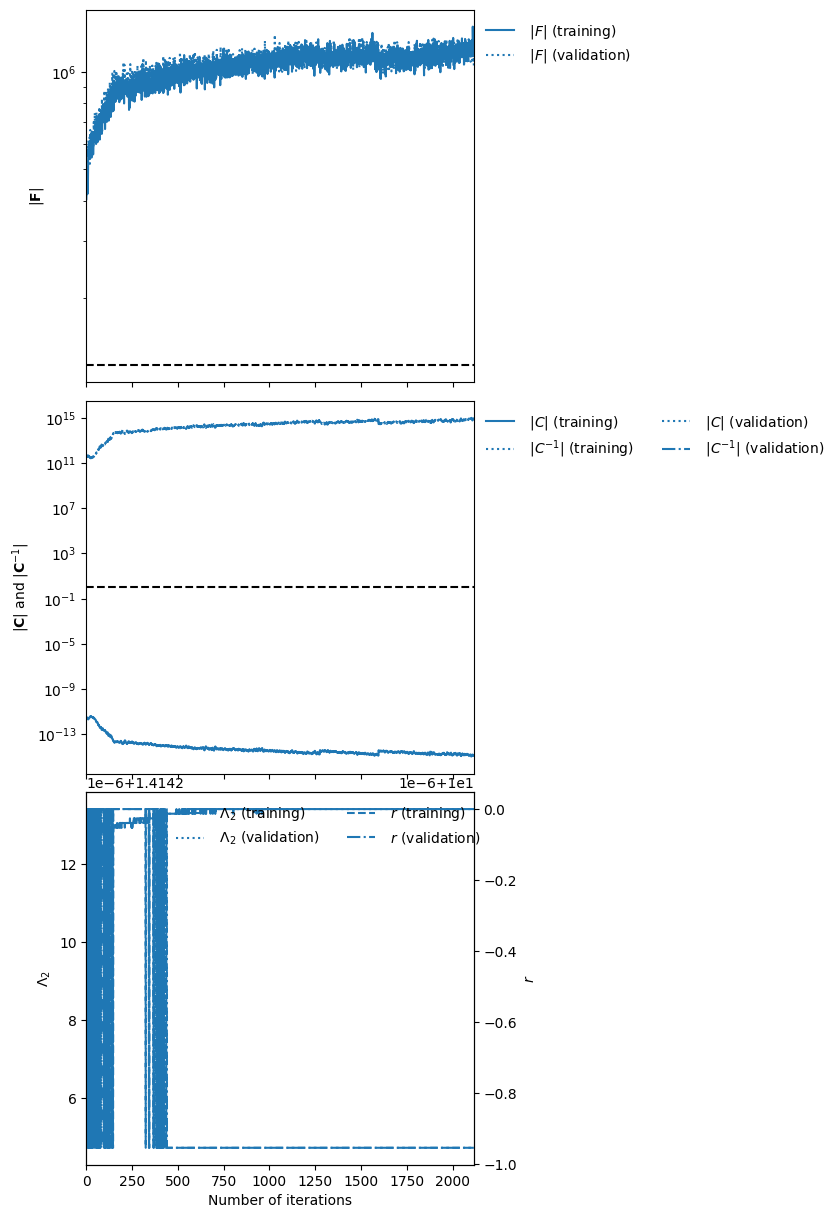

In [273]:
ax = IMNN.plot(expected_detF=jnp.linalg.det(mymoped.F))
ax[0].set_yscale("log")

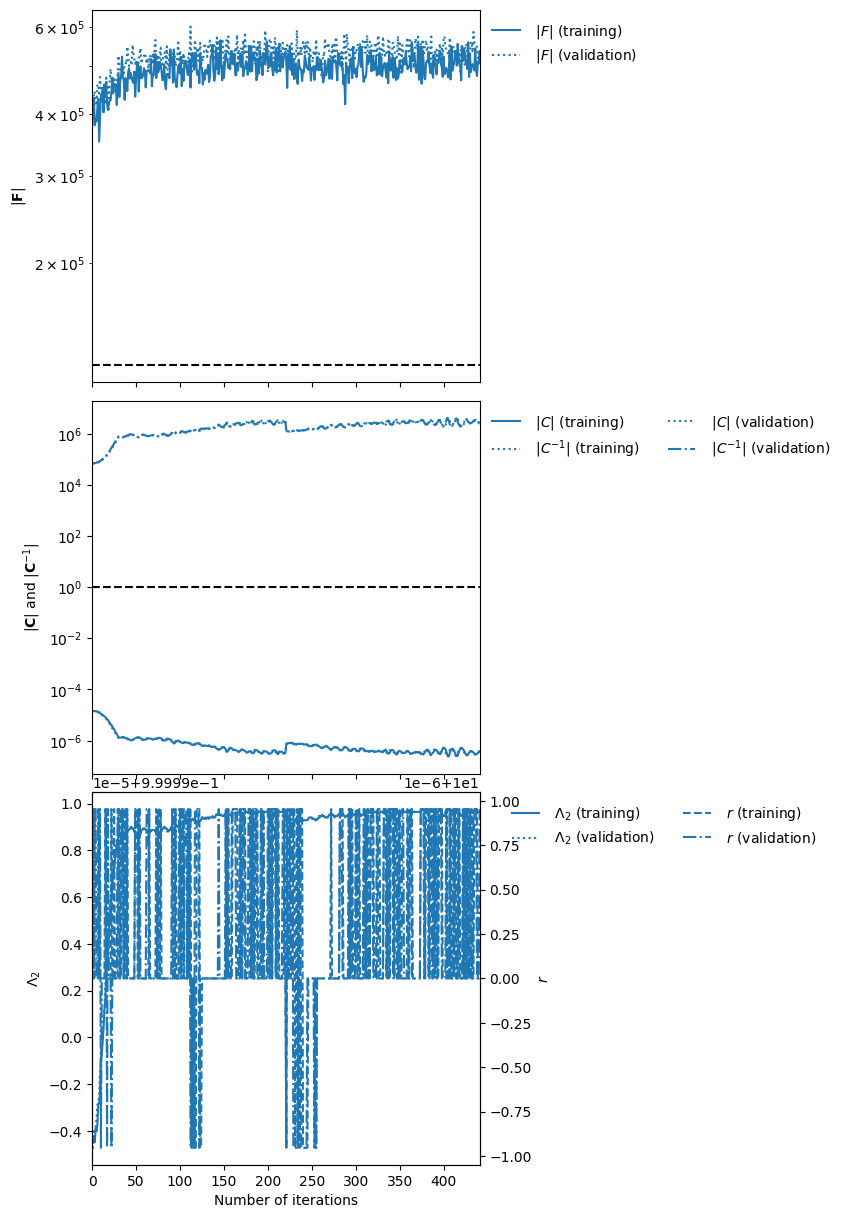

In [168]:
ax = IMNN.plot(expected_detF=jnp.linalg.det(mymoped.F))
ax[0].set_yscale("log")

In [277]:
IMNN.set_F_statistics(w=IMNN.best_w, key=model_key)

In [106]:
IMNN.F, mymoped.F

(Array([[2834.6245, 2156.7231],
        [2156.7234, 1797.0662]], dtype=float32),
 Array([[1005.01996,  605.5386 ],
        [ 605.54016,  488.19443]], dtype=float32))

In [107]:
jnp.linalg.det(IMNN.F)

Array(442553., dtype=float32)

In [108]:
jnp.linalg.det(IMNN.F) / jnp.linalg.det(mymoped.F)

Array(3.5699196, dtype=float32)

In [109]:
#@title fisher code
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

def plot_fisher_ellipse(fisher_matrix, mean=None, ax=None, color='blue', 
                        alpha=1.0, linestyle='-',
                       label=""):
    """
    Plots a Fisher information matrix ellipse.

    Parameters:
        fisher_matrix (numpy.ndarray): Fisher information matrix.
        mean (numpy.ndarray, optional): Mean vector. Defaults to None, in which case the ellipse will be centered at (0, 0).
        ax (matplotlib.axes.Axes, optional): Axes to plot on. If not provided, a new figure will be created.
        color (str, optional): Color of the ellipse. Defaults to 'blue'.
        alpha (float, optional): Transparency of the ellipse. Defaults to 0.5.
        linestyle (str, optional): Linestyle of the ellipse. Defaults to '-'.

    Returns:
        matplotlib.axes.Axes: Axes object with the ellipse plotted.
    """
    if ax is None:
        _, ax = plt.subplots()

    # Invert the Fisher information matrix to get the covariance matrix
    covariance_matrix = np.linalg.inv(fisher_matrix)

    # Calculate eigenvalues and eigenvectors of the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
    order = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[order]
    eigenvectors = eigenvectors[:, order]

    # Calculate ellipse angle
    angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))

    # If mean is provided, set the center of the ellipse accordingly
    if mean is not None:
        center = mean
    else:
        center = np.zeros_like(covariance_matrix.shape[0])

    # Create ellipse for 1-sigma contour
    ellipse = Ellipse(xy=center,
                      width=2 * np.sqrt(eigenvalues[0]),
                      height=2 * np.sqrt(eigenvalues[1]),
                      angle=angle,
                      edgecolor=color,
                      linestyle=linestyle,
                      facecolor='none',
                      alpha=alpha,
                      label=label)

    # Create ellipse for 2-sigma contour
    ellipse2 = Ellipse(xy=center,
                       width=2 * 2 * np.sqrt(eigenvalues[0]),
                       height=2 * 2 * np.sqrt(eigenvalues[1]),
                       angle=angle,
                       edgecolor=color,
                       linestyle=linestyle,
                       facecolor='none',
                       alpha=alpha)

    ax.add_patch(ellipse)
    ax.add_patch(ellipse2)
    #ax.set_aspect('equal', 'box')
    ax.autoscale()
    return ax

In [110]:
ell[:cl_cut]

Array([  50.216396,  100.43279 ,  150.64919 ,  200.86559 ,  251.08199 ,
        301.2984  ,  351.51477 ,  401.73117 ,  451.94757 ,  502.16394 ,
        552.3804  ,  602.5968  ,  652.8131  ,  703.02954 ,  753.246   ,
        803.46234 ,  853.6787  ,  903.89514 ,  954.1116  , 1004.32794 ,
       1054.5443  , 1104.7607  , 1154.977   , 1205.1936  , 1255.4099  ,
       1305.6262  , 1355.8428  , 1406.0591  , 1456.2754  , 1506.492   ,
       1556.7083  , 1606.9247  , 1657.1411  , 1707.3574  , 1757.574   ,
       1807.7903  , 1858.0066  , 1908.2231  , 1958.4395  , 2008.6558  ,
       2058.8723  , 2109.0886  , 2159.3052  , 2209.5215  , 2259.7378  ,
       2309.954   , 2360.1707  , 2410.387   , 2460.6035  , 2510.8198  ,
       2561.0361  , 2611.2527  , 2661.469   , 2711.6855  , 2761.9019  ,
       2812.1182  , 2862.3345  , 2912.551   , 2962.7673  , 3012.984   ,
       3063.2002  , 3113.4165  , 3163.6328  ], dtype=float32)

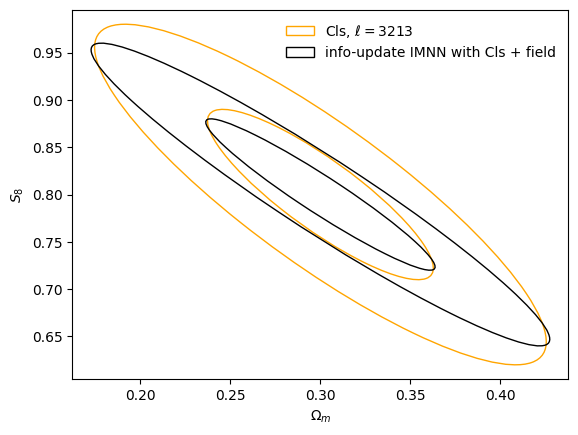

In [111]:
mean = θ_fid # Example mean vector

fishers = [mymoped.F, IMNN.F]
colours =["orange", "black", "blue"]
labels = [r"Cls, $\ell=%d$"%(ell[cl_cut]),  "info-update IMNN with Cls + field"]

for i,f in enumerate(fishers): 
    if i==0:
        ax = plot_fisher_ellipse(f, mean=mean, color=colours[i], label=labels[i])
    else:
        plot_fisher_ellipse(f, mean=mean, ax=ax, color=colours[i], label=labels[i])

plt.legend(framealpha=0.0)

plt.xlabel(r'$\Omega_m$')
plt.ylabel(r'$S_8$')
#plt.title('Fisher Information Matrix Ellipse')

#plt.grid(True)
plt.show()

In [115]:
L

250

In [326]:
save_obj(IMNN.w, outdir + "imnn_weights/NPE_stridenet_ell_2_filt_5_L_%d"%(L))

In [20]:
outdir

'/data101/makinen/lemur_sims/first_analysis/'

In [21]:
w = load_obj(outdir + "imnn_weights/weights_info_update_all_cls_S8_L_%d.pkl"%(L))

In [22]:
IMNN.set_F_statistics(w = w, key=jr.PRNGKey(0))

In [35]:
L, NOISEAMP

(500, 1.0)

In [251]:
# pull in prior 
num = 5000

# prior_sims = jnp.load(outdir + "prior_S8_L_250_N_128_Nz_512_LPT2.npz")["prior_sims"][:num]
# prior_theta = jnp.load(outdir + "prior_S8_L_250_N_128_Nz_512_LPT2.npz")["prior_theta"][:num]

prior_sims = jnp.load(outdir + "prior_new_S8_L_500_N_128_Nz_512_LPT2.npz")["prior_sims"][:num]
prior_theta = jnp.load(outdir + "prior_new_S8_L_500_N_128_Nz_512_LPT2.npz")["prior_theta"][:num]

def get_sigma8(omegam, S8):
    return S8 / (jnp.sqrt(omegam / 0.3))

def get_S8(theta):
    return np.array([theta[:, 0], theta[:, 1]*np.sqrt(theta[:, 0]/0.3)]).T


In [252]:
#prior_theta = get_S8(prior_theta)

In [253]:
key = jr.PRNGKey(333)
noisekeys = jr.split(key, num=prior_sims.shape[0])

# add in noise
prior_sims = jax.vmap(noise_simulator)(noisekeys, prior_sims)

In [254]:
# now compute Cls 

# ----- DO MOPED WITH ALL SIMS (NOISEFREE) -----
prior_cls = []
batch = 50
for i in tq(range(prior_sims.shape[0] // batch)):
    f_ = jax.vmap(cls_allbins_nonoise)(prior_sims[i*batch:(i+1)*batch]).reshape(-1, len(indices)*(num_bins))
    prior_cls.append(f_)

prior_cls = jnp.concatenate(prior_cls)


100%|██████████| 100/100 [00:01<00:00, 73.44it/s][A


In [255]:
prior_cls.shape

(5000, 60)

In [257]:
# compress with moped to get Cls summaries
moped_summaries = mymoped.compress(prior_cls)

In [258]:
batch = 500

outputs = jnp.concatenate([IMNN.get_estimate(prior_sims[i*batch:(i+1)*batch]) for i in range(prior_sims.shape[0] // batch)])

In [259]:
_appl = lambda d: IMNN.model(IMNN.w, d)

model_out_number = jnp.concatenate([jax.vmap(_appl)(prior_sims[i*batch:(i+1)*batch]) for i in range(prior_sims.shape[0] // batch)])


In [260]:
model_out_number.shape

(5000, 4)

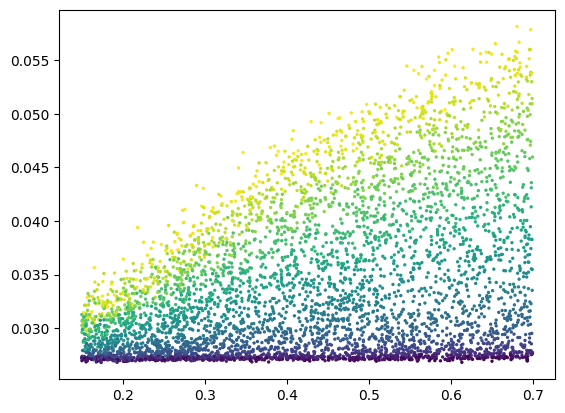

In [261]:
plt.scatter(prior_theta[:, 0], model_out_number[:, 3], s=2, c=prior_theta[:, 1])

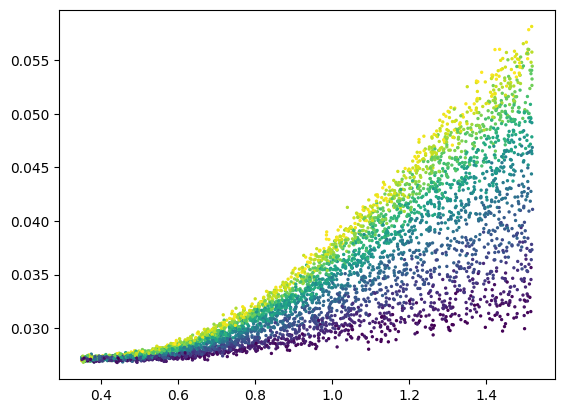

In [262]:
plt.scatter(prior_theta[:, 1], model_out_number[:, 3], s=2, c=prior_theta[:, 0])

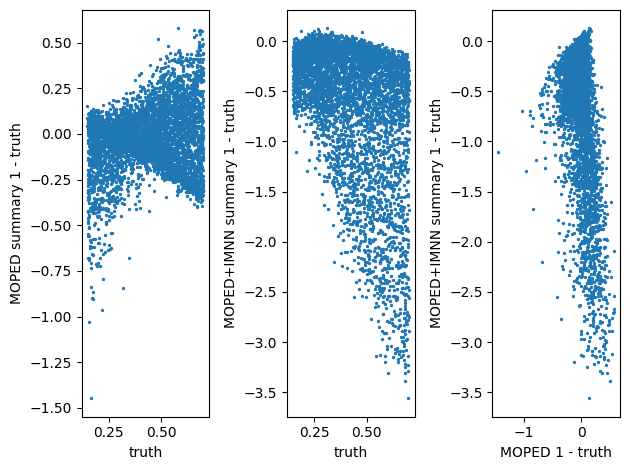

In [263]:
plt.subplot(131)
plt.scatter(prior_theta[:, 0], moped_summaries[:, 0] - prior_theta[:, 0], s=2)#, c=prior_theta[:, 1])
plt.xlabel(r"truth")
plt.ylabel(r"MOPED summary 1 - truth")

plt.subplot(132)
plt.scatter(prior_theta[:, 0], outputs[:, 0] - prior_theta[:, 0], s=2)
plt.ylabel(r"MOPED+IMNN summary 1 - truth")
plt.xlabel(r"truth")

plt.subplot(133)
plt.scatter((moped_summaries[:, 0] - prior_theta[:, 0]), outputs[:, 0] - prior_theta[:, 0], s=2)
plt.ylabel(r"MOPED+IMNN summary 1 - truth")
plt.xlabel(r"MOPED 1 - truth")

            
plt.tight_layout()

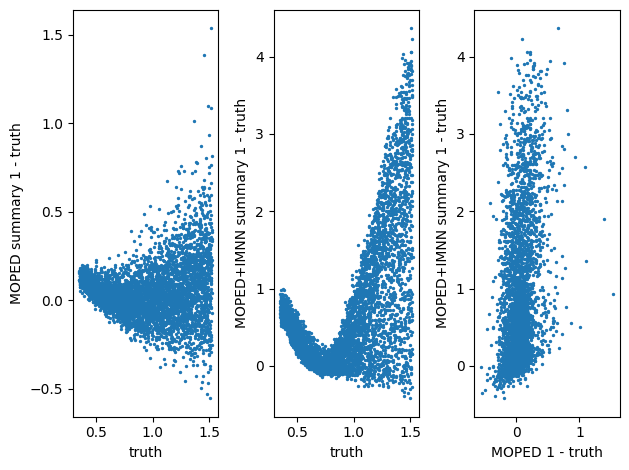

In [264]:
plt.subplot(131)
param = 1

plt.scatter(prior_theta[:, param], moped_summaries[:, param] - prior_theta[:, param], s=2)#, c=prior_theta[:, 1])
plt.xlabel(r"truth")
plt.ylabel(r"MOPED summary 1 - truth")

plt.subplot(132)
plt.scatter(prior_theta[:, param], outputs[:, param] - prior_theta[:, param], s=2)
plt.ylabel(r"MOPED+IMNN summary 1 - truth")
plt.xlabel(r"truth")

plt.subplot(133)
plt.scatter((moped_summaries[:, param] - prior_theta[:, param]), outputs[:, param] - prior_theta[:, param], s=2)
plt.ylabel(r"MOPED+IMNN summary 1 - truth")
plt.xlabel(r"MOPED 1 - truth")

            
plt.tight_layout()

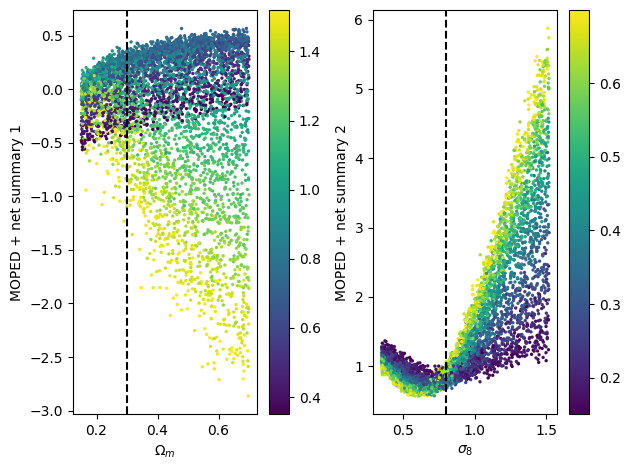

In [265]:
plt.subplot(121)
plt.scatter(prior_theta[:, 0], outputs[:, 0], s=2, c=prior_theta[:, 1])
plt.axvline(θ_fid[0], c="k", ls="--")
plt.xlabel(r"$\Omega_m$")
plt.ylabel(r"MOPED + net summary 1")
plt.colorbar()

plt.subplot(122)
plt.scatter(prior_theta[:, 1], outputs[:, 1], s=2, c=prior_theta[:, 0])
plt.axvline(θ_fid[1], c="k", ls="--")
plt.ylabel(r"MOPED + net summary 2")
plt.xlabel(r"$\sigma_8$")
plt.colorbar()

plt.tight_layout()

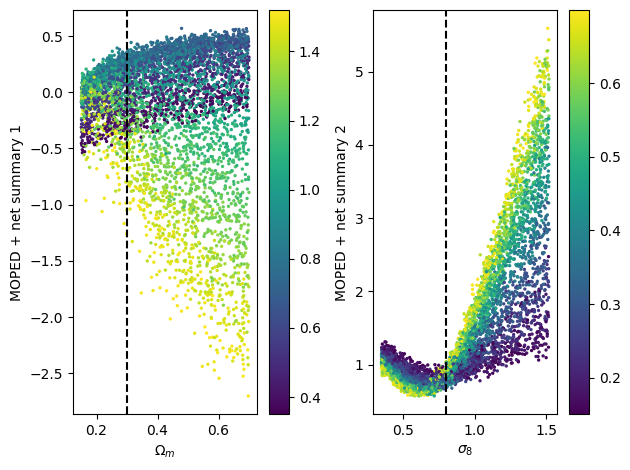

In [236]:
plt.subplot(121)
plt.scatter(prior_theta[:, 0], outputs[:, 0], s=2, c=prior_theta[:, 1])
plt.axvline(θ_fid[0], c="k", ls="--")
plt.xlabel(r"$\Omega_m$")
plt.ylabel(r"MOPED + net summary 1")
plt.colorbar()

plt.subplot(122)
plt.scatter(prior_theta[:, 1], outputs[:, 1], s=2, c=prior_theta[:, 0])
plt.axvline(θ_fid[1], c="k", ls="--")
plt.ylabel(r"MOPED + net summary 2")
plt.xlabel(r"$\sigma_8$")
plt.colorbar()

plt.tight_layout()

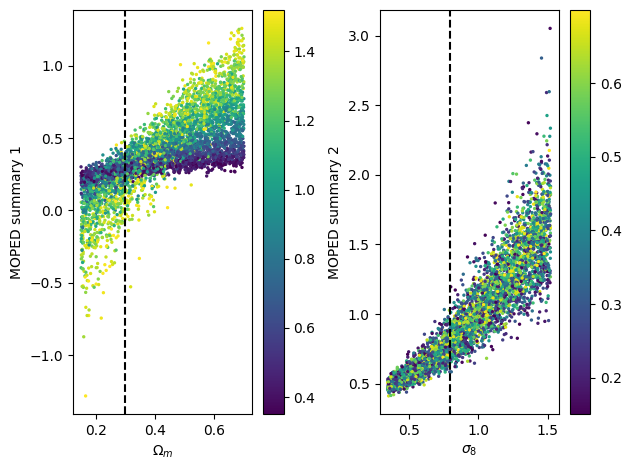

In [183]:
plt.subplot(121)
plt.scatter(prior_theta[:, 0], moped_summaries[:, 0], s=2, c=prior_theta[:, 1])
plt.axvline(θ_fid[0], c="k", ls="--")
plt.xlabel(r"$\Omega_m$")
plt.ylabel(r"MOPED summary 1")
plt.colorbar()

plt.subplot(122)
plt.scatter(prior_theta[:, 1], moped_summaries[:, 1], s=2, c=prior_theta[:, 0])
plt.axvline(0.8, c="k", ls="--")
plt.ylabel(r"MOPED summary 2")
plt.xlabel(r"$\sigma_8$")
plt.colorbar()

plt.tight_layout()

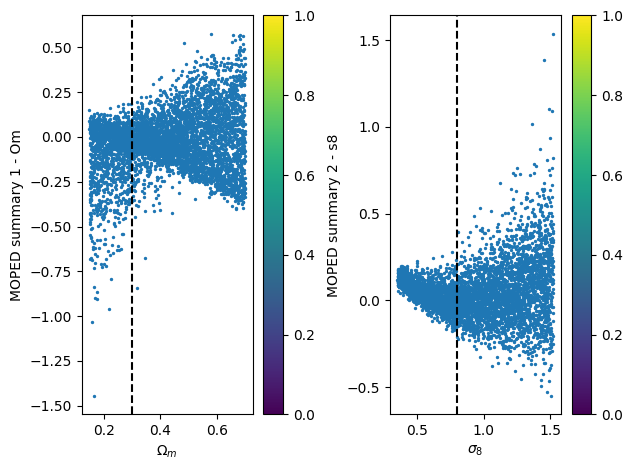

In [128]:
plt.subplot(121)
plt.scatter(prior_theta[:, 0], moped_summaries[:, 0] - prior_theta[:, 0], s=2)#, c=neural_summaries[:, 1])
plt.axvline(0.3, c="k", ls="--")

plt.xlabel(r"$\Omega_m$")
plt.ylabel(r"MOPED summary 1 - Om")
plt.colorbar()

plt.subplot(122)
plt.scatter(prior_theta[:, 1], moped_summaries[:, 1] - prior_theta[:, 1], s=2 )#, c=neural_summaries[:, 0])
plt.axvline(0.8, c="k", ls="--")
plt.ylabel(r"MOPED summary 2 - s8")
plt.xlabel(r"$\sigma_8$")
plt.colorbar()


plt.tight_layout()

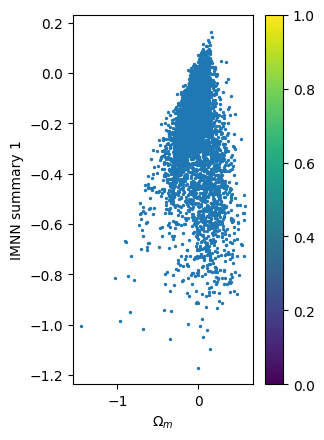

In [129]:
plt.subplot(121)
plt.scatter(moped_summaries[:, 0] - prior_theta[:, 0], outputs[:, 0] - prior_theta[:, 0], s=2)#, c=neural_summaries[:, 1])
#plt.axvline(0.3, c="k", ls="--")

plt.xlabel(r"$\Omega_m$")
plt.ylabel(r"IMNN summary 1")
plt.colorbar()

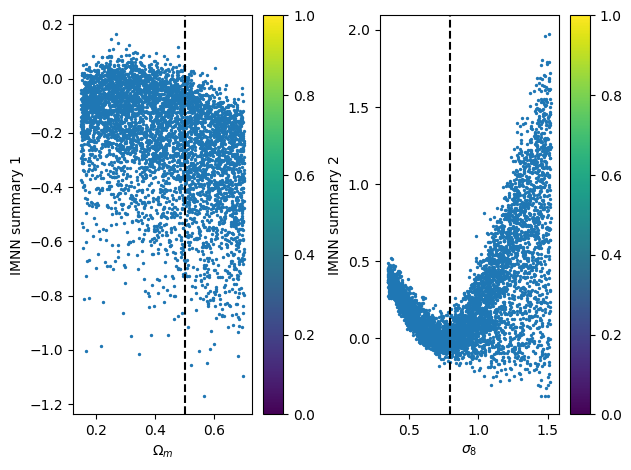

In [130]:
plt.subplot(121)
plt.scatter(prior_theta[:, 0], outputs[:, 0] - prior_theta[:, 0], s=2)#, c=neural_summaries[:, 1])
plt.axvline(0.5, c="k", ls="--")

plt.xlabel(r"$\Omega_m$")
plt.ylabel(r"IMNN summary 1")
plt.colorbar()

plt.subplot(122)
plt.scatter(prior_theta[:, 1], outputs[:, 1] - prior_theta[:, 1], s=2 )#, c=neural_summaries[:, 0])
plt.axvline(0.8, c="k", ls="--")
plt.ylabel(r"IMNN summary 2")
plt.xlabel(r"$\sigma_8$")
plt.colorbar()


plt.tight_layout()

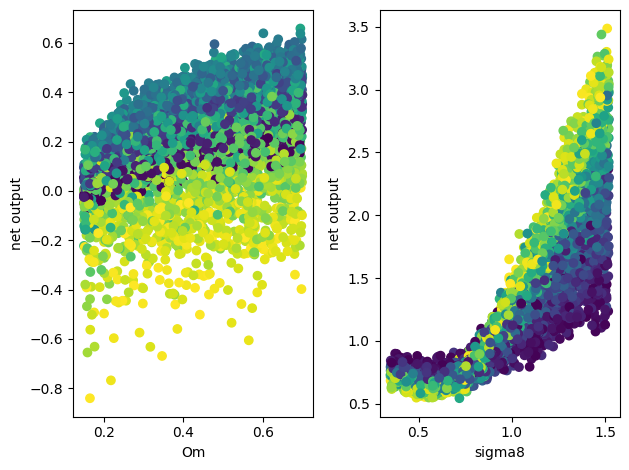

In [132]:
plt.subplot(121)
plt.scatter(prior_theta[:, 0], outputs[:, 0], c=prior_theta[:, 1])
plt.ylabel("net output")
plt.xlabel("Om")

plt.subplot(122)
plt.scatter(prior_theta[:, 1], outputs[:, 1], c=prior_theta[:, 0])
plt.ylabel("net output")
plt.xlabel("sigma8")
plt.tight_layout()

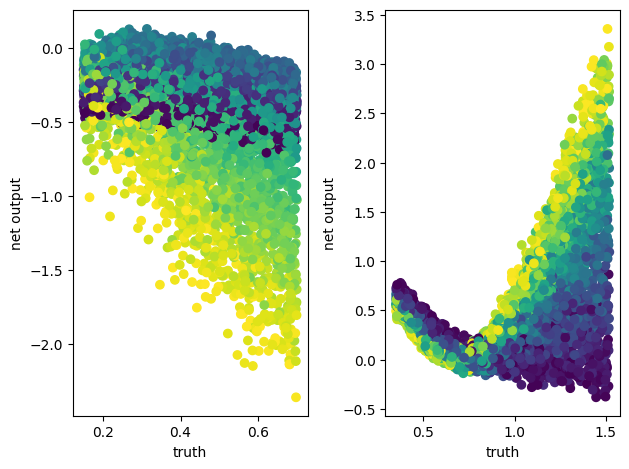

In [202]:
plt.subplot(121)
plt.scatter(prior_theta[:, 0], outputs[:, 0] - prior_theta[:, 0], c=prior_theta[:, 1])
plt.ylabel("net output")
plt.xlabel("truth")

plt.subplot(122)
plt.scatter(prior_theta[:, 1], outputs[:, 1] - prior_theta[:, 1], c=prior_theta[:, 0])
plt.ylabel("net output")
plt.xlabel("truth")
plt.tight_layout()

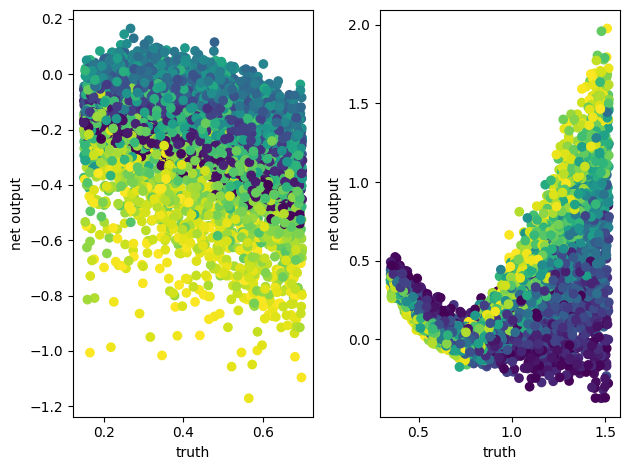

In [134]:
plt.subplot(121)
plt.scatter(prior_theta[:, 0], outputs[:, 0] - prior_theta[:, 0], c=prior_theta[:, 1])
plt.ylabel("net output")
plt.xlabel("truth")

plt.subplot(122)
plt.scatter(prior_theta[:, 1], outputs[:, 1] - prior_theta[:, 1], c=prior_theta[:, 0])
plt.ylabel("net output")
plt.xlabel("truth")
plt.tight_layout()

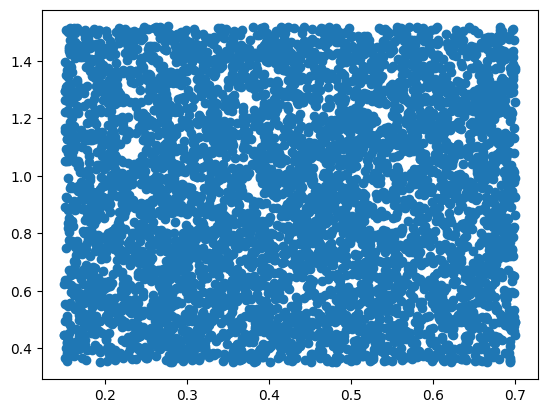

In [101]:
plt.scatter(prior_theta[:, 0], prior_theta[:, 1])

In [266]:
target = jnp.load(outdir + "target_L_%d_N_%d_Nz_512.npz"%(L, N))["kappa"]
target_theta = jnp.load(outdir + "target_L_%d_N_%d_Nz_512.npz"%(L, N))["theta"]

In [267]:
#target = fid[99]

In [268]:
noise_target_key = jax.random.PRNGKey(702)
noisy_target = noise_simulator(noise_target_key, target, rot=True)
network_target = IMNN.get_estimate(noisy_target[jnp.newaxis, ...])

moped_target = mymoped.compress(cls_allbins_nonoise(noisy_target).reshape(-1, len(indices)*(num_bins)))

In [269]:
network_target, moped_target

(Array([[0.28984714, 0.7910857 ]], dtype=float32),
 Array([[0.34779227, 0.6881933 ]], dtype=float32))

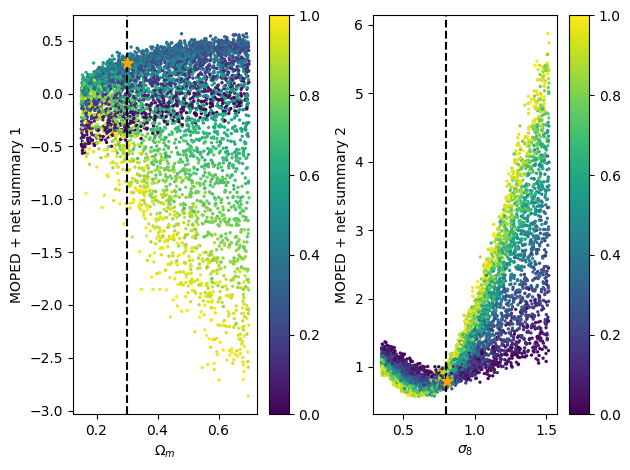

In [270]:
plt.subplot(121)
plt.scatter(prior_theta[:, 0], outputs[:, 0], s=2, c=prior_theta[:, 1])
plt.axvline(θ_fid[0], c="k", ls="--")
plt.scatter(target_theta[0], network_target[:, 0], c="orange", marker="*", s=74, zorder=23)

plt.xlabel(r"$\Omega_m$")
plt.ylabel(r"MOPED + net summary 1")
plt.colorbar()

plt.subplot(122)
plt.scatter(prior_theta[:, 1], outputs[:, 1], s=2, c=prior_theta[:, 0])
plt.axvline(θ_fid[1], c="k", ls="--")
plt.scatter(target_theta[1], network_target[:, 1], c="orange", marker="*", s=74, zorder=23)
plt.ylabel(r"MOPED + net summary 2")
plt.xlabel(r"$\sigma_8$")
plt.colorbar()

plt.tight_layout()

In [271]:
# SAVE EVERYTHING FOR DENSITY ESTIMATION !!

np.savez("S8_sbi_L250_mdn_run_L500_target_twosumms_rot3",
         moped_summaries=moped_summaries,
         #neural_summaries=neural_summaries,
         prior_theta=prior_theta,
         network_outputs=outputs,
         model_out_number=model_out_number,
         target=target,
         noisy_target=noisy_target,
         target_theta=target_theta,
         network_target=network_target,
         moped_target=moped_target
        )

In [103]:
outputs.shape

(5000, 2)

In [54]:
prior_theta.shape, outputs.shape, moped_summaries.shape

((5000, 2), (5000, 2), (5000, 2))